In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1" 
os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

import sys

from src.run_gsort_v2_wuericmod import *
import argparse
from scipy.io import loadmat
from itertools import product
import tqdm
import logging
import re
import src.utilities.electrode_map as emap

%load_ext autoreload
%autoreload 2

/Volumes/Lab/Users/jeffbrown/g-sort/src/utilities/electrode_map.py:1448: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  LITKE_512_ARRAY_ADJ_MAT = np.array([
/Volumes/Lab/Users/jeffbrown/g-sort/src/utilities/electrode_map.py:3443: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  LITKE_519_ARRAY_ADJ_MAT = np.array([


/Volumes/Lab/Users/jeffbrown/g-sort/src/utilities/visionloader.py


In [15]:
def get_center_eis_fixed_latency(n, electrode_list, ap, array_id = 1501,  num_samples = 25, snr_ratio = 1, power_threshold = 2, excluded_types = ['bad','dup'], excluded_cells = [], sample_len_left = 55,sample_len_right = 75 , with_noise = True):
    """
    Return templates and template parameters
    n: int
    electrode_list: list<int>
    ap: tuple<string, string> 
    array_id: int
    num_samples: int
    snr_ration: float
    
    output: list<int>, np.array, np.array, np.array
    """

    # Store relevant templates because on SNR on the stimulating electrode and SNR on the electrodes relevant to the cell-of-interest
    tl = TemplateLoader(ap[0], '', ap[1], array_id = array_id)
    
    if with_noise:
        tl.store_all_cells_except_with_noise(excluded_types)
    else:
        tl.store_all_cells_except(excluded_types)
    
    # Remove this condition in next set of run
    tl.remove_templates_by_list(excluded_cells)
    tl.remove_templates_with_zero_variance(electrode_list)
    tl.remove_templates_by_elec_power(electrode_list, power_threshold, num_samples)
    
    if n not in tl.cellids:
        tl.store_cells_from_list([n])

    cell_eis_all_electrodes = np.pad(np.array([tl.templates[i] for i in range(len(tl.cellids))]), ((0,0),(0,0),(sample_len_left, sample_len_right)), mode='constant')

    peak_times_all_electrodes = np.argmin(cell_eis_all_electrodes, axis=2)
    peak_value_all_electrodes = np.min(cell_eis_all_electrodes, axis=2)
    peak_electrodes = np.argmin(peak_value_all_electrodes, axis=1)
    adj_mat = emap.get_litke_array_adj_mat_by_array_id(array_id=array_id)

    cell_to_shift = [Counter() for _ in range(len(tl.cellids))]
    for i, (peak_electrode, peak_times) in enumerate(zip(peak_electrodes, peak_times_all_electrodes)):
        for surrounding_electrode in adj_mat[peak_electrode]:
            cell_to_shift[i][surrounding_electrode] = peak_times[peak_electrode]-peak_times[surrounding_electrode]



    # Align the peak of each template along each electrode
    cell_eis = np.pad(np.array([tl.templates[i][electrode_list, :] for i in range(len(tl.cellids))]), ((0,0),(0,0),(sample_len_left, sample_len_right)), mode='constant')
    cell_eis_variance = np.pad(np.array([tl.templates_variance[i][electrode_list, :]**2 for i in range(len(tl.cellids))]), ((0,0),(0,0),(sample_len_left, sample_len_right)), mode='edge')

    peak_spike_times = np.argmin(cell_eis, axis = 2)
    peak_spike_times[peak_spike_times < sample_len_left] = sample_len_left
    
    cell_eis_tmp = np.zeros((cell_eis.shape[0], cell_eis.shape[1],sample_len_left + sample_len_right))
    cell_variance_tmp = np.zeros((cell_eis.shape[0], cell_eis.shape[1],sample_len_left + sample_len_right))

    shiftable = np.zeros((len(tl.cellids), len(electrode_list)))
    
    for i in range(len(peak_spike_times)):
        for j in range(len(electrode_list)):
        
            cell_eis_tmp[i, j] = cell_eis[i,j, peak_spike_times[i][j]-sample_len_left+cell_to_shift[i][electrode_list[j]]:peak_spike_times[i][j]+sample_len_right+cell_to_shift[i][electrode_list[j]]]
            cell_variance_tmp[i, j] = cell_eis_variance[i,j, peak_spike_times[i][j]-sample_len_left+cell_to_shift[i][electrode_list[j]]:peak_spike_times[i][j]+sample_len_right+cell_to_shift[i][electrode_list[j]]]

            shiftable[i,j] = np.abs(cell_to_shift[i][electrode_list[j]]) > 0
    
    peak_spike_times = np.argmin(cell_eis_tmp, axis = 2)
    cellids = tl.cellids
    return cellids,  cell_eis_tmp, cell_variance_tmp, peak_spike_times, shiftable

In [3]:
cell = 309
k = 32
p = 433

ANALYSIS_BASE = '/Volumes/Analysis'
# dataset = '2016-06-13-0'
dataset = '2019-06-20-0'
# vstim_datarun = 'kilosort_data000/data000'
vstim_datarun = "kilosort_data000/data000"
# estim_datarun = 'data001'
estim_datarun = "data001"
vstim_analysis_path = os.path.join(ANALYSIS_BASE, dataset, vstim_datarun)

print(vstim_analysis_path)
estim_analysis_path = os.path.join(ANALYSIS_BASE, dataset, estim_datarun)
pattern_path = os.path.join(estim_analysis_path, 'pattern_files')

vstim_data = vl.load_vision_data(vstim_analysis_path,
                                 vstim_datarun.rsplit('/')[-1],
                                 include_params=True,
                                 include_ei=True,
                                 include_noise=True,
                                 include_neurons=True)
noise = vstim_data.channel_noise
duplicates, cell_ei = compute_duplicates(vstim_data, noise)

all_cell_types = [ct for ct in vstim_data.get_all_present_cell_types() if 'bad' not in ct and 'dup' not in ct]
compartments = ['soma', 'mixed']
excluded_types = ['bad', 'dup']

mutual_threshold = 1
compartments = ['soma', 'mixed']

excluded_types = ['bad', 'dup']
all_cell_types = [ct for ct in vstim_data.get_all_present_cell_types() if 'bad' not in ct and 'dup' not in ct]
cell_types= ['parasol', 'midget']
start_time_limit = 0
end_time_limit = 30
pt = 1.5
time_limit = 30

total_electrode_list, total_cell_to_electrode_list, mutual_cells, array_id = get_cell_info(all_cell_types, vstim_data, compartments, noise, mutual_threshold=mutual_threshold)

electrode_list =  list(set([e for c in mutual_cells[cell] for e in total_cell_to_electrode_list[c]]))



/Volumes/Analysis/2019-06-20-0/kilosort_data000/data000


In [16]:
data_on_cells = get_center_eis(cell, electrode_list, ap = (vstim_analysis_path[:-7], vstim_datarun.rsplit('/')[-1]), excluded_types = excluded_types, excluded_cells = list(duplicates), power_threshold=pt, array_id = array_id, sample_len_left = time_limit+20 ,sample_len_right = time_limit+20)
data_on_cells_fixed_latency = get_center_eis_fixed_latency(cell, electrode_list, ap = (vstim_analysis_path[:-7], vstim_datarun.rsplit('/')[-1]), excluded_types = excluded_types, excluded_cells = list(duplicates), power_threshold=pt, array_id = array_id, sample_len_left = time_limit+20 ,sample_len_right = time_limit+20)



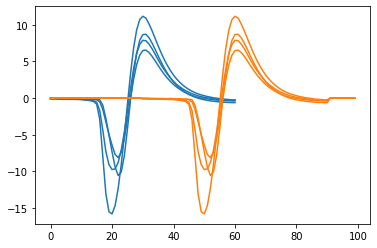

In [14]:
plt.figure()
ax = plt.subplot(111)

i = 3
test_cell = data_on_cells[0][i]

ax.plot(vstim_data.get_ei_for_cell(test_cell).ei[electrode_list].T, color = "C0")
ax.plot(data_on_cells_fixed_latency[1][i].T, color = "C1")
plt.show()

In [17]:
data_on_cells_fixed_latency[-1]

array([[0., 1., 0., 0.],
       [0., 1., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 1.],
       [0., 0., 0., 0.],
       [1., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.]])